In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math, time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

# Getting cyrpto data from alphavantage
Source: https://medium.com/codex/10-best-resources-to-fetch-cryptocurrency-data-in-python-8400cf0d0136

In [2]:
def get_crypto_price(symbol, exchange, start_date = None):
    api_key = 'YOUR API KEY'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

btc = get_crypto_price(symbol = 'BTC', exchange = 'USD', start_date = '2020-01-01')
btc



,open,high,low,close,volume
2020-01-01,7195.24,7255.00,7175.15,7200.85,16792.388165
2020-01-02,7200.77,7212.50,6924.74,6965.71,31951.483932
2020-01-03,6965.49,7405.00,6871.04,7344.96,68428.500451
2020-01-04,7345.00,7404.00,7272.21,7354.11,29987.974977
2020-01-05,7354.19,7495.00,7318.00,7358.75,38331.085604
...,...,...,...,...,...
2021-06-03,37568.68,39476.00,37170.00,39246.79,75889.106011
2021-06-04,39246.78,39289.07,35555.15,36829.00,91317.799245
2021-06-05,36829.15,37925.00,34800.00,35513.20,70459.621490
2021-06-06,35516.07,36480.00,35222.00,35796.31,47650.206637


## Bitcoin data from 2020-01-01 to 2021-06-07

In [3]:
btc.head()

,open,high,low,close,volume
2020-01-01,7195.24,7255.0,7175.15,7200.85,16792.388165
2020-01-02,7200.77,7212.5,6924.74,6965.71,31951.483932
2020-01-03,6965.49,7405.0,6871.04,7344.96,68428.500451
2020-01-04,7345.00,7404.0,7272.21,7354.11,29987.974977
2020-01-05,7354.19,7495.0,7318.00,7358.75,38331.085604


In [4]:
btc.tail()

,open,high,low,close,volume
2021-06-03,37568.68,39476.00,37170.00,39246.79,75889.106011
2021-06-04,39246.78,39289.07,35555.15,36829.00,91317.799245
2021-06-05,36829.15,37925.00,34800.00,35513.20,70459.621490
2021-06-06,35516.07,36480.00,35222.00,35796.31,47650.206637
2021-06-07,35796.31,36349.83,35498.62,36207.11,2791.886389


## Visualize openening and closing prices in the time period

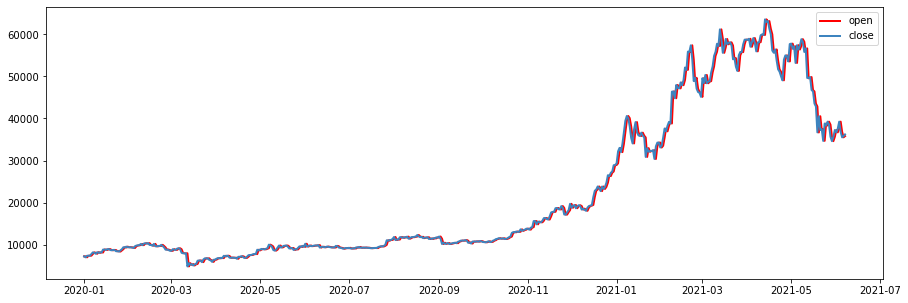

In [5]:
fig = plt.figure(figsize = (15,5))
plt.plot(btc["open"], color='r', lw=2.)
plt.plot(btc["close"], color = '#3d84bf', lw=2.)
plt.legend(["open","close"], loc='best')
plt.show()

# Model 1: LSTM

#### The first model I will be implementing is the Long Short Term Memory Networks (LSTMs) which are a special kind of RNNs that are frequently used in stock price predictions due to its ability to remember past information in time-series data.

Source: https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

#### I will be making my predictions of bitcoin prices using the opening prices

#### Normalizing data to a range between 0 and 1 because LSTMs are sensitive to large range of values


In [6]:
btc_open = btc[['open']].copy()
scaler = MinMaxScaler(feature_range=(0, 1))
btc_open['open'] = scaler.fit_transform(btc_open['open'].values.reshape(-1,1))
btc_open

,open
2020-01-01,0.040753
2020-01-02,0.040847
2020-01-03,0.036844
2020-01-04,0.043301
2020-01-05,0.043457
...,...
2021-06-03,0.557527
2021-06-04,0.586079
2021-06-05,0.544945
2021-06-06,0.522604


#### Splitting training and testing data using time step to create multiple sequences of time series data

Source: https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

In [7]:
def split_data(stock, time_step):
    data_np = stock.to_numpy()
    data = []
    
    for index in range(len(data_np) - time_step): 
        data.append(data_np[index: index + time_step])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    print(test_set_size)
    print(train_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,:]
    
    return x_train, y_train, x_test, y_test
time_step = 15 # choose sequence length
x_train, y_train, x_test, y_test = split_data(btc_open, time_step)

102
407


## Building & Training LSTM Model using keras.models

Source: https://www.youtube.com/watch?v=PuZY9q-aKLw

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [9]:
model = Sequential()
model.add(LSTM(units=148,return_sequences=True,input_shape = (x_train.shape[1],1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,epochs=200,batch_size=25)

Epoch 1/200
17/17 [==============================] - 2s 11ms/step - loss: 0.0130
Epoch 2/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0022
Epoch 3/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 4/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 5/200
17/17 [==============================] - 0s 9ms/step - loss: 9.8318e-04
Epoch 6/200
17/17 [==============================] - 0s 9ms/step - loss: 9.7556e-04
Epoch 7/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 8/200
17/17 [==============================] - 0s 9ms/step - loss: 8.9538e-04
Epoch 9/200
17/17 [==============================] - 0s 10ms/step - loss: 9.3872e-04
Epoch 10/200
17/17 [==============================] - 0s 9ms/step - loss: 8.4987e-04
Epoch 11/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 12/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 13/200
1

## Predictions using trained LSTM Model

In [10]:
lstm_predict_train= model.predict(x_train)
lstm_predict_test = model.predict(x_test)
index1 = pd.date_range("2020-01-15", periods=407, freq="D")
index2 = pd.date_range("2021-02-25", periods=102, freq="D")
lstm_predict_train = pd.DataFrame(scaler.inverse_transform(lstm_predict_train),index=index1)
y_train_lstm = pd.DataFrame(scaler.inverse_transform(y_train),index=index1)
lstm_predict_test = pd.DataFrame(scaler.inverse_transform(lstm_predict_test),index=index2)
y_test_lstm = pd.DataFrame(scaler.inverse_transform(y_test),index=index2)

## Visualize predictions vs. actual values

#### Visualize predictions on testing set vs. actual values of testing set

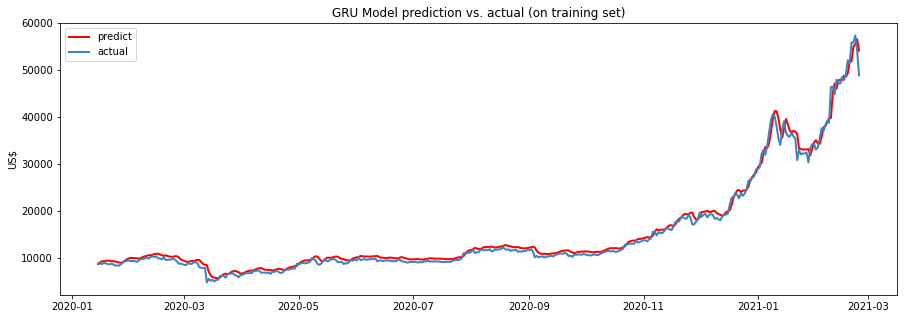

In [11]:
fig = plt.figure(figsize = (15,5))
plt.plot(lstm_predict_train, color='r', lw=2.)
plt.plot(y_train_lstm, color = '#3d84bf', lw=2.)
plt.title("GRU Model prediction vs. actual (on training set)")
plt.ylabel("US$")
plt.legend(["predict","actual"], loc='best')
plt.show()

#### Visualize predictions on testing set vs. actual values of testing set

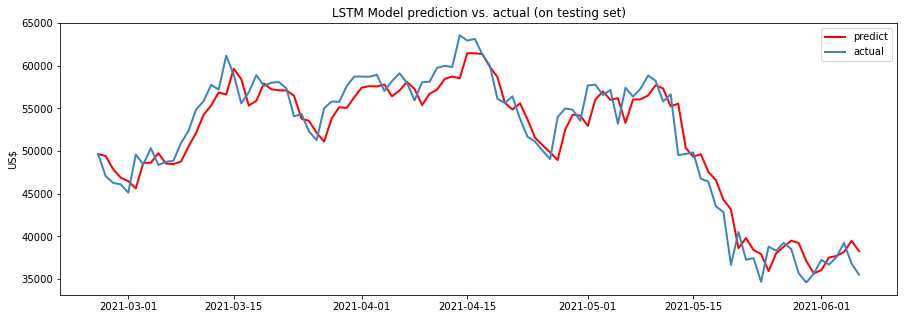

In [12]:
fig = plt.figure(figsize = (15,5))
plt.plot(lstm_predict_test, color='r', lw=2.)
plt.plot(y_test_lstm, color = '#3d84bf', lw=2.)
plt.title("LSTM Model prediction vs. actual (on testing set)")
plt.ylabel("US$")
plt.legend(["predict","actual"], loc='best')
plt.show()

## Prediction Evaluation

In [13]:
def mape_(pred,actual):
    pred = pred.values
    actual = actual.values
    return np.mean(np.abs(actual-pred)/actual)*100

print(f"R squared of training set is {r2_score(y_train_lstm,lstm_predict_train)}")
print(f"R squared of testing set is {r2_score(y_test_lstm,lstm_predict_test)}")
print(f"mean absolute error of training set is {mean_absolute_error(y_train_lstm,lstm_predict_train)}")
print(f"mean absolute error of training set is {mean_absolute_error(y_test_lstm,lstm_predict_test)}")
print(f"mean absolute percentage error of training set is {mape_(lstm_predict_train,y_train_lstm)}%")
print(f"mean absolute percentage error of testing set is {mape_(lstm_predict_test,y_test_lstm)}%")

R squared of training set is 0.9905737090912313
R squared of testing set is 0.9246459620899422
mean absolute error of training set is 759.7348482129147
mean absolute error of training set is 1719.97138939951
mean absolute percentage error of training set is 5.896584298961904%
mean absolute percentage error of testing set is 3.4542294480111617%


# Second Model: GRU

#### Second model I will be exploring is the GRU model
Source: https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

In [14]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 350

In [15]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [16]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

## Train and predict using Model

In [17]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
for t in range(num_epochs):
    y_test_pred = model(x_test)
    loss = criterion(y_test_pred, y_test_gru)
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Training time: 12.334080934524536


In [18]:
gru_predict_train = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()),index=index1)
gru_actual_train = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()),index=index1)
gru_predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().numpy()), index=index2)
gru_actual_test = pd.DataFrame(scaler.inverse_transform(y_test_gru.detach().numpy()),index=index2)

## Visualize predictions vs. actual values

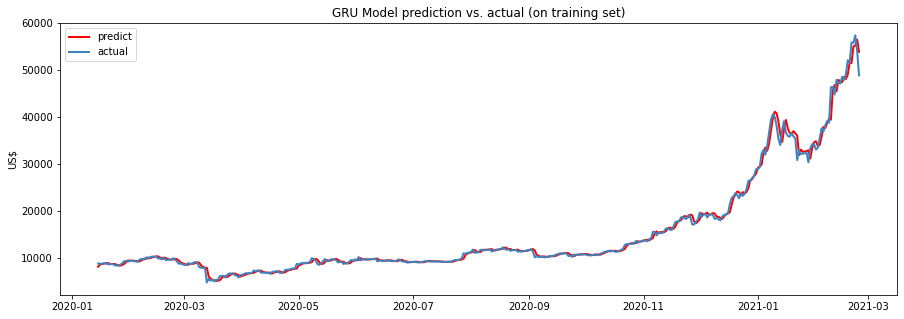

In [19]:
fig = plt.figure(figsize = (15,5))
plt.plot(gru_predict_train, color='r', lw=2.)
plt.plot(gru_actual_train, color = '#3d84bf', lw=2.)
plt.title("GRU Model prediction vs. actual (on training set)")
plt.ylabel("US$")
plt.legend(["predict","actual"], loc='best')
plt.show()

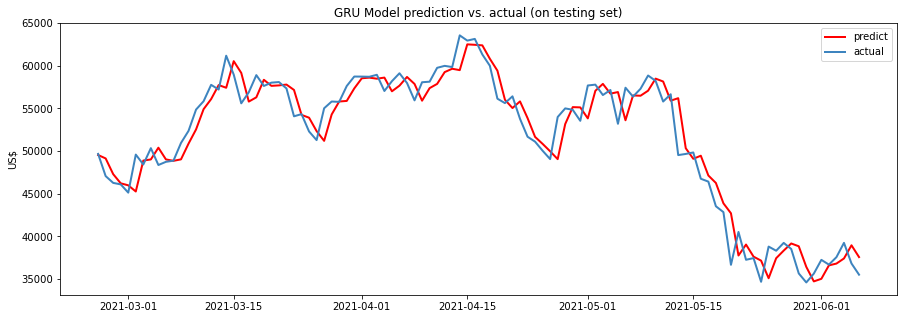

In [20]:
fig = plt.figure(figsize = (15,5))
plt.plot(gru_predict_test, color='r', lw=2.)
plt.plot(gru_actual_test, color = '#3d84bf', lw=2.)
plt.title("GRU Model prediction vs. actual (on testing set)")
plt.ylabel("US$")
plt.legend(["predict","actual"], loc='best')
plt.show()

## Prediction Evaluation

In [21]:
print(f"R squared of training set is {r2_score(gru_actual_train,gru_predict_train)}")
print(f"R squared of testing set is {r2_score(gru_actual_test,gru_predict_test)}")
print(f"mean absolute error of training set is {mean_absolute_error(gru_actual_train,gru_predict_train)}")
print(f"mean absolute error of training set is {mean_absolute_error(gru_actual_test,gru_predict_test)}")
print(f"mean absolute percentage error of training set is {mape_(gru_predict_train,gru_actual_train)}%")
print(f"mean absolute percentage error of testing set is {mape_(gru_predict_test,gru_actual_test)}%")

R squared of training set is 0.9933197228651905
R squared of testing set is 0.9330326427980575
mean absolute error of training set is 454.1497497558594
mean absolute error of training set is 1575.5732421875
mean absolute percentage error of training set is 2.7730178087949753%
mean absolute percentage error of testing set is 3.19448821246624%


# Creating a bot to buy and sell depending on predicted BTC price
#### Original Code 
Inspiration from https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe

In [38]:
prev_day_price = scaler.inverse_transform(btc_open[420:-2].values)
new = gru_predict_test.values
buys = []
buys_index = []
sells = []
sells_index = []
thresh = 0.008

for index, pred in enumerate(new):
    delta = (pred - prev_day_price[index])/prev_day_price[index]
    if delta > thresh:
        buys_index.append(index)
        buys.append(prev_day_price[index])
    elif delta <= -thresh:
        sells_index.append(index)
        sells.append(prev_day_price[index])

buys = pd.DataFrame(buys,index=btc_open[420:-2].index[buys_index]).sort_index()
sells = pd.DataFrame(sells,index=btc_open[420:-2].index[sells_index]).sort_index()

## Sequence of buying and selling action from GRU model predictions

In [39]:
buys[1],sells[1] = 'buy','sell'
exp = pd.concat([buys,sells], axis=0,join='inner')
exp = exp.sort_index()
exp

,0,1
2021-02-24,48891.00,buy
2021-02-25,49676.21,sell
2021-03-02,49595.76,sell
2021-03-03,48436.61,buy
2021-03-05,48374.09,buy
2021-03-14,61188.38,sell
2021-03-17,56900.74,sell
2021-03-18,58912.97,sell
2021-03-27,55025.59,sell
2021-04-05,58202.01,sell


## Visualize buying and selling points

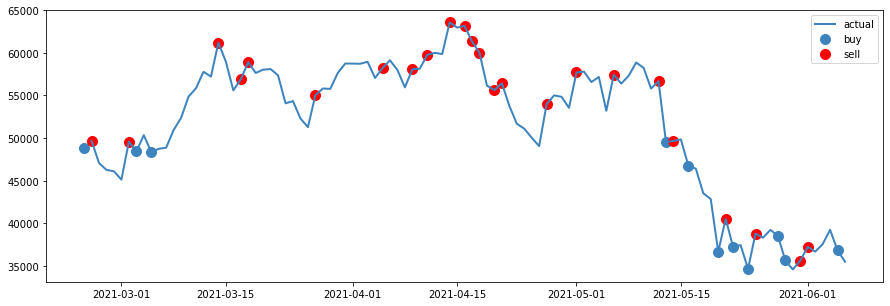

In [40]:
fig = plt.figure(figsize = (15,5))
plt.plot(gru_actual_test, color = '#3d84bf', lw=2.)
plt.scatter(buys.index,buys[0].sort_index(),color="#3d84bf", s= 100)
plt.scatter(sells.index,sells[0].sort_index(),color='r', s= 100)
plt.legend(["actual","buy","sell"], loc='best')
plt.show()

## Trying bot in action with initial balance of 1000000 dollars from 2021-02-25 to today

In [41]:
today_price = btc.iloc[-1]["open"]
total_balance = 1000000
btc_held = 0

print(f"Starting Balance on 2021-02-25 is ${1000000}.")

for i in range(exp.shape[0]):
    if exp[1][i] == 'buy':
        if btc_held < -4:
            total_balance -= exp[0][i] * btc_held * -1
            print(f"bought {btc_held * -1} bitcoin on {exp.index[i]} for {exp[0][i]} each.")
            btc_held = 0
            print(f"bitcoin held is {btc_held} and total balance is {total_balance}.")
            print("\n")
        else:
            btc_held += 1
            total_balance -= exp[0][i]
            print(f"bought 1 bitcoin on {exp.index[i]} for {exp[0][i]}.")
            print(f"bitcoin held is {btc_held} and total balance is {total_balance}.")
            print("\n")
    if exp[1][i] == 'sell':
        if btc_held > 4:
            total_balance += exp[0][i] * btc_held
            print(f"sold {btc_held} bitcoin on {exp.index[i]} for {exp[0][i]} each.")
            btc_held = 0
            print(f"bitcoin held is {btc_held} and total balance is {total_balance}.")
            print("\n")
        else:
            btc_held -= 1
            total_balance += exp[0][i]
            print(f"sold 1 bitcoin on {exp.index[i]} for {exp[0][i]} each.")
            print(f"bitcoin held is {btc_held} and total balance is {total_balance}.")
            print("\n")
            
cumulative_balance = total_balance + btc_held * today_price
print(f"Remaining Balance on 2021-06-06 is ${total_balance}.")
print(f"Total Bitcoin held right now is {btc_held}.")
print(f"Bitcoin Price today is {today_price}.")
print(f"Cumulative balance is {cumulative_balance}, profit/loss of {(cumulative_balance - 1000000)/1000000 * 100}%")

Starting Balance on 2021-02-25 is $1000000.
bought 1 bitcoin on 2021-02-24 00:00:00 for 48891.0.
bitcoin held is 1 and total balance is 951109.0.


sold 1 bitcoin on 2021-02-25 00:00:00 for 49676.21 each.
bitcoin held is 0 and total balance is 1000785.21.


sold 1 bitcoin on 2021-03-02 00:00:00 for 49595.76 each.
bitcoin held is -1 and total balance is 1050380.97.


bought 1 bitcoin on 2021-03-03 00:00:00 for 48436.61.
bitcoin held is 0 and total balance is 1001944.36.


bought 1 bitcoin on 2021-03-05 00:00:00 for 48374.09.
bitcoin held is 1 and total balance is 953570.27.


sold 1 bitcoin on 2021-03-14 00:00:00 for 61188.380000000005 each.
bitcoin held is 0 and total balance is 1014758.65.


sold 1 bitcoin on 2021-03-17 00:00:00 for 56900.74 each.
bitcoin held is -1 and total balance is 1071659.3900000001.


sold 1 bitcoin on 2021-03-18 00:00:00 for 58912.97000000001 each.
bitcoin held is -2 and total balance is 1130572.36.


sold 1 bitcoin on 2021-03-27 00:00:00 for 55025.59 each.
bi

# Total profit of 16.209% ! 